In [1]:
import os
from ordereddict import OrderedDict
os.environ['THEANO_FLAGS']="device=cpu"

from utils import tile_raster_images
from pylearn2.utils import serial
import theano
import theano.tensor as T

try:
    import PIL.Image as Image
except ImportError:
    import Image
import IPython.display as I

In [2]:
DIR_DATA = '/Users/vmisra/data/AE_experiments'
dir_model = os.path.join(DIR_DATA,'models')
dir_fuel = os.path.join(DIR_DATA,'fuel')

#Load models and data

In [3]:
model_folders = [model_folder \
               for model_folder in os.listdir(dir_model) \
               if os.path.isdir(os.path.join(dir_model,model_folder))]
model_folders = ['Z1_100','Z1c_90']
submodels = ['0.pkl','1.pkl','2.pkl','3.pkl','finetune.pkl']

In [4]:
models = OrderedDict()
for model_folder in model_folders:
    models[model_folder] = OrderedDict()
    for submodel in submodels:
        path = os.path.join(dir_model,model_folder,submodel)
        if os.path.exists(path):
            models[model_folder][submodel] = serial.load(path)

MemoryError: ('Error allocating 4000000 bytes of device memory (out of memory).', <function CudaNdarray_unpickler at 0x1099dd8c0>, (array([[-0.02893753, -0.05197882,  0.00486204, ..., -0.02868285,
         0.02203207,  0.05578731],
       [-0.05556913, -0.0007303 ,  0.04425307, ..., -0.05473905,
         0.06002805,  0.00230238],
       [-0.03587576,  0.03078373, -0.00226475, ...,  0.0084594 ,
        -0.00335145, -0.01291932],
       ..., 
       [ 0.00769758,  0.0197146 ,  0.05459732, ...,  0.01917958,
        -0.0130586 ,  0.07830396],
       [-0.00389576, -0.00377664,  0.04876404, ...,  0.03649851,
         0.03234813, -0.03060262],
       [-0.02424004, -0.0238542 , -0.03631607, ...,  0.02796244,
         0.0037832 , -0.0017608 ]], dtype=float32),))

In [48]:
import collections

In [5]:
test_data = serial.load(os.path.join(dir_fuel,'mnist_test_X.pkl'))

#Define graph

In [35]:
Xs = [model['finetune.pkl'.get_input_space().make_theano_batch() for model in models]
#Ys = [model.fprop(X) for (model,X) in zip(models,Xs)]
Ys = [model.reconstruct(X) for (model,X) in zip(models,Xs)]
Yfirsts = [firstmodel.reconstruct(X) for (firstmodel,X) in zip(firstmodels,Xs)]
Yseconds = [firstmodel.decode(secondmodel.reconstruct(firstmodel.encode(X))) for (firstmodel,secondmodel,X) in zip(firstmodels,secondmodels,Xs)]
Ythirds = [firstmodel.decode(secondmodel.decode(thirdmodel.decode(thirdmodel.encode(secondmodel.encode(firstmodel.encode(X)))))) for (firstmodel,secondmodel,thirdmodel,fourthmodel,X) in zip(firstmodels,secondmodels,thirdmodels,fourthmodels,Xs)]
Yfourths = [firstmodel.decode(secondmodel.decode(thirdmodel.decode(fourthmodel.decode(fourthmodel.encode(thirdmodel.encode(secondmodel.encode(firstmodel.encode(X)))))))) for (firstmodel,secondmodel,thirdmodel,fourthmodel,X) in zip(firstmodels,secondmodels,thirdmodels,fourthmodels,Xs)]


#Compute output

In [36]:
Xhats = [Y.eval({X:test_data}) for (X,Y) in zip(Xs,Ys)]
Xfirsthats = [Y.eval({X:test_data}) for (X,Y) in zip(Xs,Yfirsts)]
Xsecondhats = [Y.eval({X:test_data}) for (X,Y) in zip(Xs,Yseconds)]
Xthirdhats = [Y.eval({X:test_data}) for (X,Y) in zip(Xs,Ythirds)]
Xfourthhats = [Y.eval({X:test_data}) for (X,Y) in zip(Xs,Yfourths)]

##visualize outputs

original


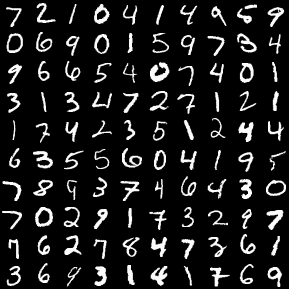

In [8]:
original_img = Image.fromarray(tile_raster_images(X=test_data,
                                                  img_shape=(28,28),
                                                  tile_shape=(10,10),
                                                  tile_spacing=(1,1)))
original_img.save('delete_me.png')
print 'original'
I.display(I.Image('delete_me.png'))

Z1c_90


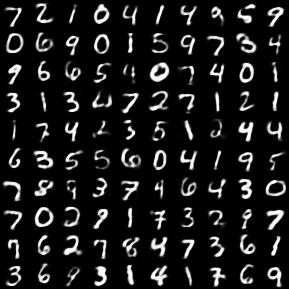

Z1c_90


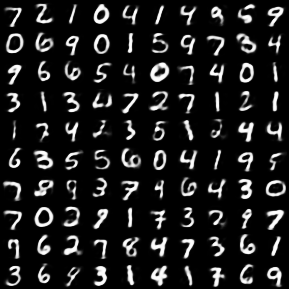

Z1c_90


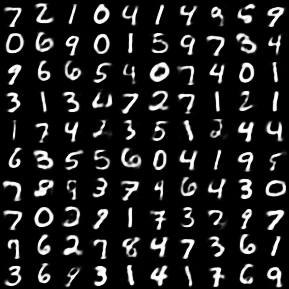

Z1c_90


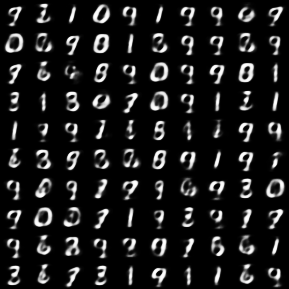

Z1c_90


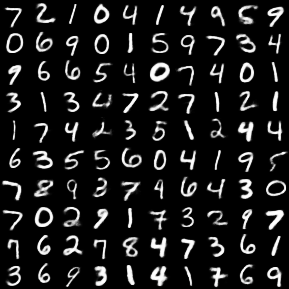

In [38]:
for (xhat,model_folder) in zip(Xfirsthats+Xsecondhats+Xthirdhats+Xfourthhats+Xhats,model_folders*5):
    reconstructed = Image.fromarray(tile_raster_images(X=xhat,
                                                  img_shape=(28,28),
                                                  tile_shape=(10,10),
                                                  tile_spacing=(1,1)))
    reconstructed.save('delete_me.png')
    print model_folder
    I.display(I.Image('delete_me.png'))

In [43]:
model_folders = ['Z1_100']
import cPickle as pickle
params = [pickle.load(open(os.path.join(dir_model,model_folder,'params.pkl'),'r')) for model_folder in model_folders]

In [44]:
params

[{'corruptions': [0.1, 0.2, 0.3, 0.3],
  'dec_activations': ['"sigmoid"', '"sigmoid"', '"sigmoid"', '"sigmoid"'],
  'dir_fuel': '/home/ubuntu/data/AE_experiments/fuel',
  'dir_models': '/home/ubuntu/data/AE_experiments/models/Z1',
  'enc_activations': ['"sigmoid"', '"sigmoid"', '"sigmoid"', '"sigmoid"'],
  'finetune_batch_size': 100,
  'finetune_cost_YAML': '!obj:train_AE.XtropyReconstructionCost',
  'finetune_epochs': 300,
  'monitoring_batches': 5,
  'n_units': [784, 1000, 1000, 1000, 15],
  'path_YAML_finetune': 'finetune_simpletrain.yaml',
  'paths_YAML_pretrains': ['layer0_skeleton.yaml',
   'layer1_skeleton.yaml',
   'layer2_skeleton.yaml',
   'layer3_skeleton.yaml'],
  'pretrain_batch_size': 100,
  'pretrain_cost_YAML': '!obj:train_AE.MeanSquaredReconstructionCost',
  'pretrain_epochs': 5,
  'train_stop': 50000,
  'valid_stop': 60000}]